In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 从文件加载数据$X,y,\Theta$

In [2]:
data_mat = loadmat('ex4data1.mat')
print(data_mat.keys())
data_mat['X'].shape,data_mat['y'].shape, # X的每一行是样本，每一列是特征

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


((5000, 400), (5000, 1))

In [3]:
theta_mat = loadmat('ex4weights.mat')
print(theta_mat.keys())
theta_mat['Theta1'].shape,theta_mat['Theta2'].shape #看出每一行则是一组theta

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])


((25, 401), (10, 26))

(100, 400)


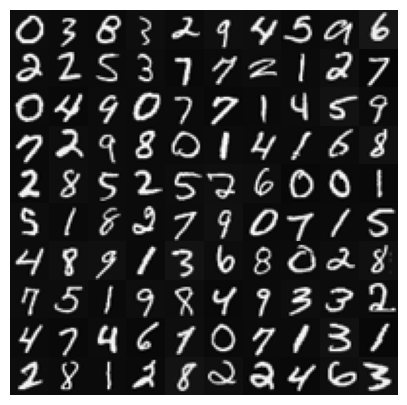

In [4]:
sample_indices = np.random.choice(data_mat['X'].shape[0], 100, replace = False)
samples = data_mat['X'][sample_indices]
print(samples.shape)
fig, axes = plt.subplots(10, 10, figsize=(5, 5), gridspec_kw={'wspace': 0, 'hspace': 0})
for i, ax in enumerate(axes.flat):
    imgdata = samples[i].reshape(20,20,order='F')
    ax.imshow(imgdata, cmap='gray')  # 使用灰度色彩映射显示
    ax.axis('off')
plt.show()

# 定义加权Z函数，A激活函数，代价函数cost及含正则项的代价函数reCost
- 由于大多数教程在看到X输入时，每个样本都作为列向量输入加权值z时采用theta @ X，所以单个样本都作为列向量考虑,每一组theta作为横向量表示<br>
- 因此在以下定义的函数及计算过程中，会将X处理成每一列为样本，每一行为特征，当然y也会变成每l列为样本对应的标签值<br>

In [5]:
# 将X,y,权重 做转置处理，这样可以与课程保持一致，方便理解
X,y = data_mat['X'].T,data_mat['y'].T
theta_l1,theta_l2= theta_mat['Theta1'],theta_mat['Theta2']

# 标签数据转化
y2broadcast = np.tile(np.arange(1,11).reshape(10,1),(1,5000))
y2vector = (np.tile(y,(10,1)) == y2broadcast).astype(int)

# 一共三层，第一层有s1个神经元，第二层有s2个神经元，第三层有s3个神经元,不含bias unit
s1,s2,s3 = 400,25,10
# 获得权重形状并随机初始化
W_l1_shape, W_l2_shape = (s2,s1+1), (s3,s2+1)
W_size_l1, W_size_l2 = s2*(s1+1), s3*(s2+1)
W_size = W_size_l1 + W_size_l2

# 包在一起方便用
netWorkInf = {
    's1' : s1,
    's2' : s2,
    's3' : s3,
    'W_l1_shape' : W_l1_shape,
    'W_l2_shape' : W_l2_shape,
    'W_size_l1' : W_size_l1,
    'W_size_l2' : W_size_l2,
    'W_size' : W_size,
    'X' : X,
    'y' : y2vector
}

In [13]:
def biasInsert_row(array):
    return np.insert(array,0,1,axis = 0)
def zFunc(X,theta):
    X = biasInsert_row(X)
    return theta @ X
def aFunc(z):
    return 1/(1+np.exp(-z))
def a_prime(z):
    return aFunc(z)*(1-(aFunc(z)))
def cost(theta_l1,theta_l2,a3,y,lamda=0):
    m = a3.shape[1]
    noRe_cost = np.sum(-y * np.log(a3) - (1 - y) * np.log(1 - a3))/a3.shape[1]
    re = lamda/(2*m)*(np.sum(theta_l1[:,1:]**2)+np.sum(theta_l2[:,1:]**2))
    return noRe_cost+re

## 思路
$\huge \delta^{(l)}_{j}$ erros of cost for $\huge a^{(l)}_{j}$     ( Unit $j$ in layer $l$ )<br><br>
$\huge \delta^{(l)}_{j}=\frac{\partial}{\partial z^{(l)}_{j}}cost(X,y,\Theta^{(1)},\Theta^{(2)},...)$<br><br>
$\huge \delta^{(l)}=(\Theta^{(l)})^{T}\delta^{(l+1)}*g^{'}(z^{(l)})$<br><br>
$\huge \Delta^{(l)} = a^{(l)}\delta^{(l+1)} $

### 第一步：正向计算<br>
- 定义神经网络结构
- 初始化权重，注意每一列代表的是一组权重<br>
- 正向计算，获得每一层的z值和a值<br>
- 反向传播，计算每一层的$\delta$
- 计算每一层的$\huge \Delta$ ,也就是$\huge \frac{\partial}{\partial \Theta^{(l)}}cost()$

In [ ]:
def forward_propagate(W,netWorkInf,lamda = 0):    
    X,y = netWorkInf['X'],netWorkInf['y']
    W_l1 = W[:netWorkInf['W_size_l1']].reshape(netWorkInf['W_l1_shape'])
    W_l2 = W[netWorkInf['W_size_l1']:].reshape(netWorkInf['W_l2_shape'])
    
    a1 = X
    z2 = zFunc(a1,W_l1)
    a2 = aFunc(z2)
    z3 = zFunc(a2,W_l2)
    a3 = aFunc(z3)
    
    J = cost(W_l1,W_l2,a3,y,lamda)
    
    fresult = {
        'a1': a1,
        'z2': z2,
        'a2': a2,
        'z3': z3,
        'a3': a3,
        'J': J,
    }
    return fresult
def back_propagate(W,netWorkInf,lamda = 0):
    # 获取X和y数据，还有样本数量
    X,y = netWorkInf['X'],netWorkInf['y'] 
    m = X.shape[1]

    # 获得 W_l1和 W_l2，初始化的数据在W中，前面是1后面是2
    W_l1 = W[:netWorkInf['W_size_l1']].reshape(netWorkInf['W_l1_shape'])
    W_l2 = W[netWorkInf['W_size_l1']:].reshape(netWorkInf['W_l2_shape'])

    # 初始化梯度，都为0
    grad_l1 = np.zeros(W_l1.shape)
    grad_l2 = np.zeros(W_l2.shape)

    #获得正向传播的各层数据
    fresult = forward_propagate(W,netWorkInf,lamda)
    J = fresult['J']

    #####反向传播，计算各项数据
    #先算delta
    delta3 = fresult['a3']-y # 最后一层的delta,(10.5000)    
    z2 = fresult['z2'] # 形状为(25,5000)
    delta2 = (W_l2.T @ delta3)[1:] * a_prime(z2) #形状依次为(10, 26) (10, 5000) (25, 5000),结果为(25,5000)

    #再算grad
    a2 = biasInsert_row(fresult['a2']) #(26,5000)
    grad_l2 = delta3 @ a2.T / m #(10,26)
    a1 = biasInsert_row(fresult['a1']) #(401,5000)
    grad_l1 = delta2 @ a1.T / m #（25,401）
    
    reGrad_l1 = grad_l1 +  lamda/m * W_l1
    reGrad_l2 = grad_l2 +  lamda/m * W_l2

    # unravel the gradient matrices into a single array
    reGrad = np.concatenate((np.ravel(reGrad_l1), np.ravel(reGrad_l2)))

    bresult = {
        'delta3': delta3,
        'delta2': delta2,
        'grad_l1': grad_l1,
        'grad_l2': grad_l2,
        'reGrad_l1': reGrad_l1,
        'reGrad_l2': reGrad_l2,
        'reGrad': reGrad,
        'J': J,
    }
    print('1*>',end='')
    return J,reGrad

In [14]:
# 初始化权重数据，由于优化函数接受的一半是一个一维数组，所以把权重数据合在一起
W = np.random.uniform(-0.12,0.12,size = W_size)

back_propagate(W,netWorkInf)

(6.728376918103688,
 array([0.01503384, 0.        , 0.        , ..., 0.17135097, 0.17668302,
        0.17662649]))

In [65]:
from scipy.optimize import minimize
lamda = 10
# minimize the objective function
fmin = minimize(fun=back_propagate, x0=W, args=(netWorkInf,lamda), 
                method='TNC',jac = True, options={'maxfun': 100})
fmin

 message: Max. number of function evaluations reached
 success: False
  status: 3
     fun: 1.0787977000954738
       x: [-4.710e-02 -1.044e-02 ...  6.217e-01  6.019e-01]
     nit: 12
     jac: [-3.859e-04 -2.087e-05 ... -1.349e-03 -1.845e-03]
    nfev: 101

In [62]:
w1 = fmin.x[:W_size_l1].reshape(W_l1_shape)
w2 = fmin.x[W_size_l1:].reshape(W_l2_shape)
fr = forward_propagate(fmin.x,netWorkInf,lamda = 1)
fr['J']

0.5171881377660549

In [63]:
def acc(W,fresult):
    predict = fresult['a3'].argmax(0)+1
    crrectNum = np.sum((predict == y).astype(int))
    acc = crrectNum / 5000
    return acc

In [64]:
acc(fmin.x,fr)

0.9482

## 梯度检测

In [57]:
# 定义一个微笑增量epsilon
epsilon = 1e-7

def gradCheck(params,grad,epsilon,index=None):
    gc = []
    if index == None:
        index = params.size()
    gc_params = params[index]
    for i,param in zip(index,gc_params):
        p = params.copy()
        p[i] = param-epsilon
        j_minus = forward_propagate(p,netWorkInf)['J']
        # 计算plus的损失值
        p[i] = param+epsilon
        j_plus = forward_propagate(p,netWorkInf)['J']
        # 计算检车的梯度值
        g = (j_plus-j_minus)/(2*epsilon)
        gc.append(g)
        print(i,end='*->')
    np.array(gc)

    diff = np.linalg.norm( gc- grad[index]) / (np.linalg.norm(gc) + np.linalg.norm(grad[index]))
    return diff,gc,params[index]
params = fmin.x
grad = fmin.jac
diff,gc,go =gradCheck(params,grad,epsilon,range(5))

0*->1*->2*->3*->4*->

In [58]:
diff

3.275562504618117e-08